In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
mpl.style.available
mpl.style.use('ggplot') 
from IPython.display import display, HTML
from itertools import cycle, islice
from matplotlib.font_manager import FontProperties
from bokeh.plotting import figure, output_file, show
import datetime as dt 
from IPython.display import clear_output
import sklearn

from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_selection import RFE
from time import time
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import GridSearchCV
from collections import OrderedDict

In [4]:
df = pd.read_pickle("./customer_df_with_engineered_features.pkl")
df.fillna(0,inplace = True)

## Find optimal number of estimators using OOB error

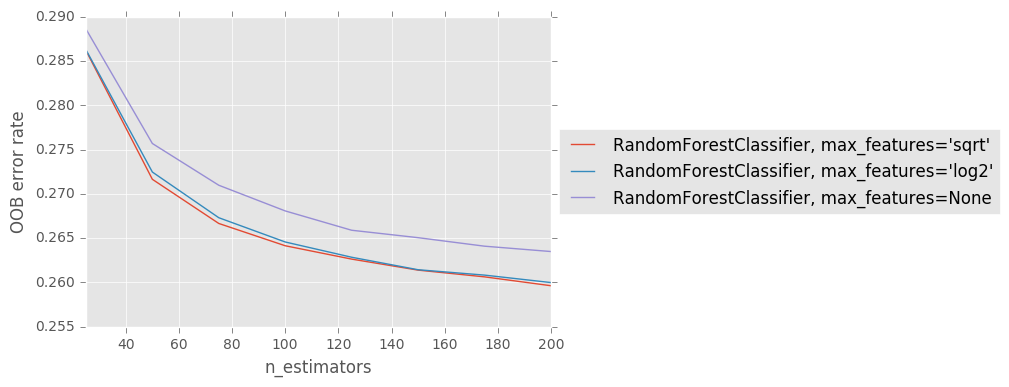

In [6]:
y = df.churn_label

y = np.ravel(y)

## Use all features
X = df.drop(
    ['customer_id', 'churn_label', 'gender', 'country', 'date_created',
       'YOB', 'premier', 'account_age', 'account_age_months','rounded_total_spent'], axis = 1)

# Scale data
scaler = StandardScaler()
X = scaler.fit_transform(X)


RANDOM_STATE = 666

ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE, 
                              )),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE, 
                               )),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE, 
                               ))
]


# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 25
max_estimators = 200

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 25):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Do the same for maximum depth

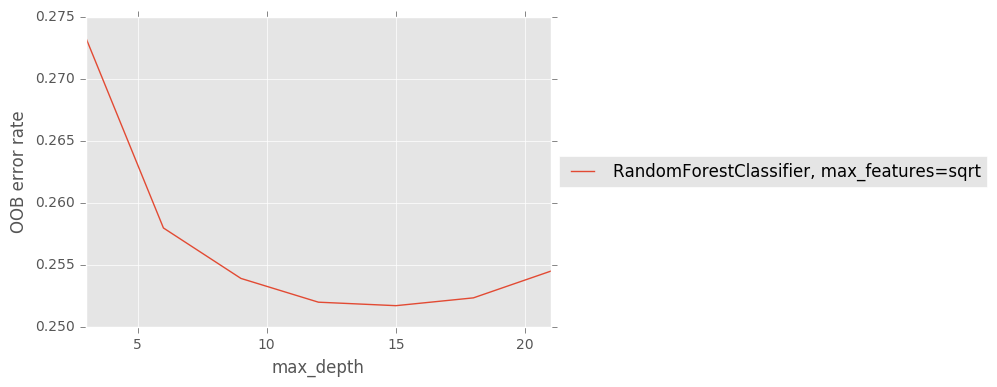

In [7]:
## Use all features
X = df.drop(
    ['customer_id', 'churn_label', 'gender', 'country', 'date_created',
       'YOB', 'premier', 'account_age', 'account_age_months','rounded_total_spent'], axis = 1)

# Scale data
scaler = StandardScaler()
X = scaler.fit_transform(X)


RANDOM_STATE = 666

ensemble_clfs = [

    ("RandomForestClassifier, max_features=sqrt",
        RandomForestClassifier(oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE,
                               n_estimators = 125
                               ))
]


# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_max_depth = 3
max_max_depth = 21

for label, clf in ensemble_clfs:
    for i in range(min_max_depth, max_max_depth + 1, 3):
        clf.set_params(max_depth=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "max_depth" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_max_depth, max_max_depth)
plt.xlabel("max_depth")
plt.ylabel("OOB error rate")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()